In [2]:
import scipy
import scipy.misc
import numpy as np
import random
import pandas as pd
import gym
from tqdm import tqdm
from tqdm import tqdm_notebook
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import lasagne
import theano.tensor as T
import theano

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
class LunarLanding_wrapper():
    def __init__(self):
        self.state_size = (1, 8)
        self.game_title = "LunarLander-v2"
        self.actions = ["DO_NOTHING", "FIRE_LEFT", "FIRE_MAIN", "FIRE_RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [6]:
class CartPole_wrapper():
    def __init__(self):
        self.state_size = (1, 4)
        self.game_title = "CartPole-v0"
        self.actions = ["LEFT", "RIGHT"]
        self.n_actions = len(self.actions)
        try:
            self.env = gym.make(self.game_title)
        except:
            print ("ERROR : Can't find " + self.game_title + " environment.")
            return None
        self.env.reset()
    
    def processState(self, state):
        return state.reshape(1, -1)
    
    def processAction(self, action):
        return action
    
    def make_reset(self):
        state = self.env.reset()
    
        return self.processState(state)
    
    def make_step(self, action, render = False):
        action = self.processAction(action)
    
        state, ret1, ret2, ret3 = self.env.step(action)
    
        if render:
            self.env.render()
    
        return self.processState(state), ret1, ret2, ret3

In [7]:
class AVQ_nn():
    def __init__(self, channels_number = 4, image_shape = (1, 8), n_actions = 4, grad_clipping = 10, lr = 0.0001, h = 50, alpha = 25):
        self.input_var = T.tensor4('input')
        
        self.n_actions = n_actions
        self.build_network(channels_number, image_shape)
        self.build_AVQ(grad_clipping, lr, h, alpha)
        self.compile_network()
        
    def build_network(self, channels_number, image_shape):
        self.l1 = lasagne.layers.InputLayer(shape=(None, channels_number, image_shape[0], image_shape[1]), 
                                            input_var = self.input_var)
        self.l2 = lasagne.layers.DenseLayer(self.l1, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.l3 = lasagne.layers.DenseLayer(self.l2, 40, nonlinearity=lasagne.nonlinearities.leaky_rectify)
        self.outlayer = lasagne.layers.DenseLayer(self.l3, 50, nonlinearity=lasagne.nonlinearities.leaky_rectify)
    
    def build_AVQ(self, grad_clipping, lr, h, alpha):
        self.l_advantage = lasagne.layers.DenseLayer(self.outlayer, self.n_actions)
        self.l_value = lasagne.layers.DenseLayer(self.outlayer, 1)
        self.l_varq = lasagne.layers.DenseLayer(self.outlayer, self.n_actions, nonlinearity=lasagne.nonlinearities.softplus)
        
        self.advantage, self.value, self.varq = lasagne.layers.get_output([self.l_advantage, self.l_value, self.l_varq])

        self.average_advantage = T.mean(self.advantage, keepdims = True, axis = 1)
        
#        self.Q = self.advantage + self.value - self.average_advantage
        self.Q = self.advantage
        self.predict = T.argmax(self.Q, axis = 1)
        
        self.targetQ = T.fvector('targetQ')
        self.actions = T.ivector('actions')
        self.actions_onehot = T.extra_ops.to_one_hot(self.actions, self.n_actions, dtype=np.float32)
        
        self.Q0 = T.sum(self.Q * self.actions_onehot, axis = 1)
        self.varQ0 = T.sum(self.varq * self.actions_onehot, axis = 1)
        
        self.Q1 = self.Q0 + (self.targetQ - self.Q0) / (h + 1)
        self.varQ1 = (h * (alpha - 1)) / ((h + 1) * (alpha - 0.5)) * \
                     (self.varQ0 + T.sqr(self.targetQ - self.Q0) / (2 * (h+1) * (alpha - 1)))
        
        self.td_error = T.mean(T.sqr(self.Q1 - self.Q0))
        self.var_error = T.mean(T.sqr(self.varQ1 - self.varQ0))
        self.loss = self.td_error + self.var_error
        
        params = self.get_all_params()
        self.all_grads = T.grad(self.loss, params)
        self.scaled_grads = lasagne.updates.total_norm_constraint(self.all_grads, grad_clipping)
        self.updates = lasagne.updates.adam(self.scaled_grads, params, learning_rate=lr)
        
    def compile_network(self):
        self.Qout_fn = theano.function([self.input_var], self.Q)
        self.actionpred_fn = theano.function([self.input_var], self.predict)
        self.train_fn = theano.function([self.input_var, self.targetQ, self.actions], [self.loss, self.Q1, self.varQ1], updates = self.updates)
        self.var_fn = theano.function([self.input_var], self.varq)
    
    def get_all_params(self):
#        return lasagne.layers.get_all_params([self.l_advantage, self.l_value], trainable = True)
        return lasagne.layers.get_all_params([self.l_advantage, self.l_varq], trainable = True)
    
    def get_all_params_values(self):
#        return lasagne.layers.get_all_param_values([self.l_advantage, self.l_value], trainable = True)
        return lasagne.layers.get_all_param_values([self.l_advantage, self.l_varq], trainable = True)
    
    def set_all_params_values(self, values):
#        return lasagne.layers.set_all_param_values([self.l_advantage, self.l_value], values, trainable = True)
        return lasagne.layers.set_all_param_values([self.l_advantage, self.l_varq], values, trainable = True)

In [8]:
class experience_buffer():
    def __init__(self, buffer_size = 10000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))-self.buffer_size] = []
        self.buffer.extend(experience)
            
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [9]:
class window_aggregator():
    def __init__(self, window_length, state_shape):
        self.state_shape = state_shape
        self.window_length = window_length
        
        assert len(self.state_shape) == 2
        assert self.window_length >= 1
        
        self.start_aggregator_shape = (window_length, state_shape[0], state_shape[1])
                                             
        self.aggregator = np.zeros(self.start_aggregator_shape)
        
    def reset(self):
        self.aggregator = np.zeros(self.start_aggregator_shape)
                                       
    def add_state(self, state):
        state = np.expand_dims(state, 0)
        self.aggregator = np.append(self.aggregator, state, axis = 0)
    
    def get_window(self):
        return self.aggregator[-self.window_length:,:,:]                                                                           

In [10]:
class egreedy_agent():
    def __init__(self, n_actions, actionpred_fn, startE = 1, endE = 0.1, anneling_steps = 50000):
        self.startE = startE
        self.endE = endE
        self.anneling_steps = anneling_steps
        self.stepE = (self.startE - self.endE) / self.anneling_steps
        self.n_actions = n_actions
        self.actionpred_fn = actionpred_fn
    
    def choose_action(self, state, current_step):
        if current_step > self.anneling_steps:
            epsilon = self.endE
        else:
            epsilon = self.startE - self.stepE * current_step
        
        if np.random.rand(1) < epsilon:
            a = np.random.randint(0, self.n_actions)
        else:
            a = self.actionpred_fn(np.expand_dims(state, axis = 0))[0]
            
        return a

In [11]:
class boltzman_agent:
    def __init__(self, n_actions, Qout_fn, startT = 1000, endT = 0.1, anneling_steps = 50000):
        self.startT = startT
        self.endT = endT
        self.anneling_steps = anneling_steps
        self.logstep = (np.log(startT) - np.log(endT)) / anneling_steps
        self.n_actions = n_actions
        self.Qout_fn = Qout_fn
    
    def choose_action(self, state, current_step):
        scores = self.Qout_fn(np.expand_dims(state, axis = 0))[0]
        if current_step > self.anneling_steps:
            exponents = np.exp((scores - np.max(scores)) / self.endT)
        else:
            current_temp = self.startT / np.exp(self.logstep * current_step)
            exponents = np.exp((scores - np.max(scores)) / current_temp)
        probs = exponents / np.sum(exponents)
        return np.random.choice(self.n_actions, p = probs)

In [12]:
class bayes_agent():
    def __init__(self, n_actions, actionpred_fn, var_fn, startE = 1, endE = 0.1, anneling_steps = 50000):
        self.startE = startE
        self.endE = endE
        self.anneling_steps = anneling_steps
        self.stepE = (self.startE - self.endE) / self.anneling_steps
        self.n_actions = n_actions
        self.actionpred_fn = actionpred_fn
        self.var_fn = var_fn
    
    def choose_action(self, state, current_step):
        if current_step > self.anneling_steps:
            epsilon = self.endE
        else:
            epsilon = self.startE - self.stepE * current_step
        
        if np.random.rand(1) < epsilon:
            scores = self.var_fn(np.expand_dims(state, axis = 0))
            a = np.argmax(scores)
        else:
            a = self.actionpred_fn(np.expand_dims(state, axis = 0))[0]
            
        return a

In [13]:
class DDQL():
    def __init__(self, lparams, env, agent = {"agent":"egreedy", "params":{}}):
        self.grad_clip = lparams["grad_clipping"]
        self.lr = lparams["learning_rate"]
        self.window_size = lparams["window_size"]
        self.batch_size = lparams["batch_size"]
        self.gamma = lparams["gamma"]
        self.h = lparams["lambda"]
        self.alpha = lparams["alpha"]
        self.MQN_updatefreq = lparams["MQN_updatefreq"]
        self.TQN_updatefreq = lparams["TQN_updatefreq"]
        self.TQN_updaterate = lparams["TQN_updaterate"]
        self.print_freq = lparams["print_freq"]
        self.pretrain_steps = lparams["pretrain_steps"]
        self.buffer_size = lparams["buffer_size"]
        self.pretrain_over = False
        
        self.env = env
        AVQ_params = [self.window_size, self.env.state_size, self.env.n_actions, 
                      self.grad_clip, self.lr, self.h, self.alpha]
        self.mainQN = AVQ_nn(*AVQ_params)
        self.targetQN = AVQ_nn(*AVQ_params)

        self.jList = []
        self.rList = []
        self.total_steps = 0
        
        self.window = window_aggregator(self.window_size, self.env.state_size)
        self.experience_storage = experience_buffer(self.buffer_size)
        self.agent = self.getAgent(agent["agent"], agent["params"])
            
    def getAgent(self, agent, agentparams):
        if agent == "egreedy":
            return egreedy_agent(self.env.n_actions, self.mainQN.actionpred_fn, **agentparams)
        elif agent == "boltzman":
            return boltzman_agent(self.env.n_actions, self.mainQN.Qout_fn, **agentparams)
        elif agent == "bayes":
            return bayes_agent(self.env.n_actions, self.mainQN.actionpred_fn, self.mainQN.var_fn, **agentparams)
        else:
            raise ValueError("Unknown agent")
            
    def updateTarget(self, completeupdate = False):
        if completeupdate:
            self.targetQN.set_all_params_values(self.mainQN.get_all_params_values())
        else:
            targetparams = self.targetQN.get_all_params_values()
            mainparams = self.mainQN.get_all_params_values()
            ur = self.TQN_updaterate
        
            assert len(targetparams) == len(mainparams)
            for k in range(0, len(targetparams)):
                targetparams[k] = targetparams[k] * (1.0 - ur) + mainparams[k] * ur
        
            self.targetQN.set_all_params_values(targetparams)

    def train(self, num_episodes, frame_limit, render = True):
        self.updateTarget(True)
        self.window.reset()
            
        for episode_num in tqdm_notebook(range(num_episodes), desc = "RL train"):
            state = self.env.make_reset()
            self.window.add_state(state)
            window_state = self.window.get_window()
            episode_rewards = np.zeros(frame_limit)
                
            for iteration in xrange(0, frame_limit):
                action = self.agent.choose_action(window_state, self.total_steps)
                new_state, reward, gameover, _ = self.env.make_step(action, render)
                self.window.add_state(new_state)
                new_window_state = self.window.get_window()
                self.experience_storage.add(np.reshape(np.array([window_state, action, reward, new_window_state, gameover]),[1,5]))
                episode_rewards[iteration] = reward
                
                if self.pretrain_over:
                    self.total_steps += 1
                
                    if self.total_steps % (self.TQN_updatefreq) == 0:
                        self.updateTarget()
                
                    if self.total_steps % (self.MQN_updatefreq) == 0:
                        train_batch = self.experience_storage.sample(self.batch_size)
                        old_state_batch = np.stack(train_batch[:,0])
                        new_state_batch = np.stack(train_batch[:,3])
                        action_vector = (train_batch[:,1]).astype(np.int32)
                        end_multiplier = -(train_batch[:,4] - 1)
                        rewards_vector = train_batch[:,2]
                        
                        Q1 = self.mainQN.actionpred_fn(new_state_batch)   
                        Q2 = self.targetQN.Qout_fn(new_state_batch)
                        
                        
                        doubleQ = Q2[range(self.batch_size),Q1]
                        targetQ = (rewards_vector + (self.gamma * doubleQ * end_multiplier)).astype(np.float32)
                        loss, Qval, Qvar = self.mainQN.train_fn(old_state_batch, targetQ, action_vector)
                         
                else:
                    self.pretrain_steps -= 1;
                    if self.pretrain_steps <= 0:
                        self.pretrain_over = True
                        
                state = new_state
                window_state = new_window_state
            
                if gameover:
                    self.window.reset()
                    break
    
            total_reward = np.sum(episode_rewards)
            self.jList.append(iteration)
            self.rList.append(total_reward)
            if len(self.rList) % self.print_freq == 0:
                tqdm.write(" ".join(["========= Episode", str(episode_num), "================================================"]))
                tqdm.write(" ".join(["Total steps:", str(self.total_steps)]))
                tqdm.write(" ".join(["Episode rewards, last 10:", str(self.rList[-10:])]))
                tqdm.write(" ".join(["Mean over last", str(self.print_freq), "episodes:", str(np.mean(self.rList[-self.print_freq:]))]))
                tqdm.write(" ".join(["Episode lengths, last 10:", str(self.jList[-10:])]))
                tqdm.write("===================================================================" + "=" * len(str(episode_num)))

In [14]:
def plot_rewards(ddqlmodel, meanwindow = 250):
    rlist = [ddqlmodel.rList[0]] * meanwindow + ddqlmodel.rList
    x = np.cumsum(ddqlmodel.jList)
    y = [np.mean(rlist[k:k+meanwindow]) for k in range(len(rlist) - meanwindow)]
    plt.plot(x, y)

In [15]:
#llenv = LunarLanding_wrapper()
cp_env = CartPole_wrapper()

[2017-05-15 18:41:51,322] Making new env: CartPole-v0


In [16]:
lparams = {"grad_clipping" : 50,
           "learning_rate" : 0.005,
           "window_size" : 1,
           "batch_size" : 8,
           "buffer_size" : 128,
           "gamma" : 0.98,
           "lambda": 4,
           "alpha": 2,
           "MQN_updatefreq" : 1,
           "TQN_updatefreq" : 4,
           "TQN_updaterate" : 0.2,
           "print_freq" : 500,
           "pretrain_steps" : 5000,
           "render" : False}

In [17]:
egreedyagentinfo = {"agent" : "egreedy",
                    "params" : {"startE": 0.5,
                                "endE" : 0.1,
                                "anneling_steps":1000}}

In [18]:
boltzmanagentinfo = {"agent" : "boltzman",
                     "params" : {"startT": 10,
                                 "endT" : 1,
                                 "anneling_steps":10000}}

In [19]:
bayesagentinfo = {"agent" : "bayes",
                    "params" : {"startE": 0.5,
                                "endE" : 0.1,
                                "anneling_steps":1000}}

In [20]:
def produce_experiment(ddql, ddql_init_params, ddql_train_params, experiment_num = 5):
    ddql_list = [ddql(**ddql_init_params) for k in range(experiment_num)]
    
    for k in range(experiment_num):
        ddql_list[k].train(**ddql_train_params)
        
    return ddql_list

In [21]:
ddql_bayes_params = {"lparams":lparams, "env":cp_env, "agent":bayesagentinfo}

ddql_train_params = {"num_episodes":2500, "frame_limit":500, "render":False}

In [22]:
res = produce_experiment(DDQL, ddql_bayes_params, ddql_train_params, 10)

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 0
Episode rewards, last 10: [10.0, 9.0, 10.0, 9.0, 9.0, 9.0, 10.0, 10.0, 9.0, 10.0]
Mean over last 500 episodes: 9.746
Episode lengths, last 10: [9, 8, 9, 8, 8, 8, 9, 9, 8, 9]
========= Episode 999 ================================================
Total steps: 87959
Episode rewards, last 10: [197.0, 207.0, 233.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Mean over last 500 episodes: 176.172
Episode lengths, last 10: [196, 206, 232, 499, 499, 499, 499, 499, 499, 499]
========= Episode 1499 ================================================
Total steps: 200131
Episode rewards, last 10: [500.0, 500.0, 500.0, 500.0, 500.0, 17.0, 14.0, 49.0, 14.0, 127.0]
Mean over last 500 episodes: 224.344
Episode lengths, last 10: [499, 499, 499, 499, 499, 16, 13, 48, 13, 126]
========= Episode 1999 ================================================
Total steps: 300938
Episode rewards, last 10: [500.0, 500.0, 500.0, 330.

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 3272
Episode rewards, last 10: [9.0, 11.0, 9.0, 16.0, 11.0, 12.0, 11.0, 9.0, 10.0, 12.0]
Mean over last 500 episodes: 16.544
Episode lengths, last 10: [8, 10, 8, 15, 10, 11, 10, 8, 9, 11]
========= Episode 999 ================================================
Total steps: 46110
Episode rewards, last 10: [150.0, 158.0, 138.0, 147.0, 272.0, 500.0, 246.0, 82.0, 191.0, 156.0]
Mean over last 500 episodes: 85.676
Episode lengths, last 10: [149, 157, 137, 146, 271, 499, 245, 81, 190, 155]
========= Episode 1499 ================================================
Total steps: 158692
Episode rewards, last 10: [114.0, 17.0, 26.0, 26.0, 11.0, 81.0, 100.0, 380.0, 500.0, 500.0]
Mean over last 500 episodes: 225.164
Episode lengths, last 10: [113, 16, 25, 25, 10, 80, 99, 379, 499, 499]
========= Episode 1999 ================================================
Total steps: 249613
Episode rewards, last 10: [275.0, 125.0, 13.0,

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 40989
Episode rewards, last 10: [165.0, 180.0, 281.0, 468.0, 65.0, 264.0, 121.0, 111.0, 13.0, 143.0]
Mean over last 500 episodes: 91.978
Episode lengths, last 10: [164, 179, 280, 467, 64, 263, 120, 110, 12, 142]
========= Episode 999 ================================================
Total steps: 146846
Episode rewards, last 10: [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 379.0, 71.0, 48.0, 13.0]
Mean over last 500 episodes: 211.714
Episode lengths, last 10: [499, 499, 499, 499, 499, 499, 378, 70, 47, 12]
========= Episode 1499 ================================================
Total steps: 249578
Episode rewards, last 10: [72.0, 15.0, 71.0, 56.0, 500.0, 500.0, 500.0, 258.0, 500.0, 216.0]
Mean over last 500 episodes: 205.464
Episode lengths, last 10: [71, 14, 70, 55, 499, 499, 499, 257, 499, 215]
========= Episode 1999 ================================================
Total steps: 353937
Episode rewards, last

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 33343
Episode rewards, last 10: [500.0, 500.0, 209.0, 84.0, 31.0, 176.0, 437.0, 52.0, 30.0, 48.0]
Mean over last 500 episodes: 76.686
Episode lengths, last 10: [499, 499, 208, 83, 30, 175, 436, 51, 29, 47]
========= Episode 999 ================================================
Total steps: 150037
Episode rewards, last 10: [23.0, 20.0, 94.0, 198.0, 97.0, 146.0, 133.0, 500.0, 500.0, 500.0]
Mean over last 500 episodes: 233.388
Episode lengths, last 10: [22, 19, 93, 197, 96, 145, 132, 499, 499, 499]
========= Episode 1499 ================================================
Total steps: 266628
Episode rewards, last 10: [80.0, 81.0, 73.0, 44.0, 364.0, 129.0, 24.0, 16.0, 116.0, 176.0]
Mean over last 500 episodes: 233.182
Episode lengths, last 10: [79, 80, 72, 43, 363, 128, 23, 15, 115, 175]
========= Episode 1999 ================================================
Total steps: 384455
Episode rewards, last 10: [500.0,

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 1977
Episode rewards, last 10: [165.0, 215.0, 166.0, 217.0, 65.0, 28.0, 38.0, 34.0, 9.0, 10.0]
Mean over last 500 episodes: 13.954
Episode lengths, last 10: [164, 214, 165, 216, 64, 27, 37, 33, 8, 9]
========= Episode 999 ================================================
Total steps: 87065
Episode rewards, last 10: [183.0, 171.0, 310.0, 176.0, 257.0, 139.0, 167.0, 147.0, 153.0, 215.0]
Mean over last 500 episodes: 170.176
Episode lengths, last 10: [182, 170, 309, 175, 256, 138, 166, 146, 152, 214]
========= Episode 1499 ================================================
Total steps: 193689
Episode rewards, last 10: [351.0, 143.0, 64.0, 29.0, 304.0, 90.0, 129.0, 154.0, 93.0, 338.0]
Mean over last 500 episodes: 213.248
Episode lengths, last 10: [350, 142, 63, 28, 303, 89, 128, 153, 92, 337]
========= Episode 1999 ================================================
Total steps: 300819
Episode rewards, last 10: [1

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 50492
Episode rewards, last 10: [232.0, 195.0, 204.0, 152.0, 155.0, 156.0, 152.0, 174.0, 225.0, 280.0]
Mean over last 500 episodes: 110.984
Episode lengths, last 10: [231, 194, 203, 151, 154, 155, 151, 173, 224, 279]
========= Episode 999 ================================================
Total steps: 152126
Episode rewards, last 10: [42.0, 15.0, 14.0, 11.0, 15.0, 20.0, 17.0, 110.0, 158.0, 500.0]
Mean over last 500 episodes: 203.268
Episode lengths, last 10: [41, 14, 13, 10, 14, 19, 16, 109, 157, 499]
========= Episode 1499 ================================================
Total steps: 255197
Episode rewards, last 10: [89.0, 500.0, 500.0, 407.0, 163.0, 345.0, 306.0, 490.0, 500.0, 500.0]
Mean over last 500 episodes: 206.142
Episode lengths, last 10: [88, 499, 499, 406, 162, 344, 305, 489, 499, 499]
========= Episode 1999 ================================================
Total steps: 351074
Episode rewards, l

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 0
Episode rewards, last 10: [9.0, 9.0, 10.0, 8.0, 10.0, 12.0, 9.0, 9.0, 10.0, 9.0]
Mean over last 500 episodes: 9.542
Episode lengths, last 10: [8, 8, 9, 7, 9, 11, 8, 8, 9, 8]
========= Episode 999 ================================================
Total steps: 68061
Episode rewards, last 10: [11.0, 20.0, 19.0, 36.0, 18.0, 33.0, 9.0, 31.0, 40.0, 500.0]
Mean over last 500 episodes: 136.58
Episode lengths, last 10: [10, 19, 18, 35, 17, 32, 8, 30, 39, 499]
========= Episode 1499 ================================================
Total steps: 151942
Episode rewards, last 10: [360.0, 128.0, 170.0, 103.0, 15.0, 102.0, 91.0, 74.0, 79.0, 16.0]
Mean over last 500 episodes: 167.762
Episode lengths, last 10: [359, 127, 169, 102, 14, 101, 90, 73, 78, 15]
========= Episode 1999 ================================================
Total steps: 248696
Episode rewards, last 10: [23.0, 22.0, 16.0, 16.0, 18.0, 102.0, 11.0, 24.0,

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 1166
Episode rewards, last 10: [28.0, 10.0, 13.0, 25.0, 15.0, 68.0, 120.0, 59.0, 10.0, 14.0]
Mean over last 500 episodes: 12.332
Episode lengths, last 10: [27, 9, 12, 24, 14, 67, 119, 58, 9, 13]
========= Episode 999 ================================================
Total steps: 96822
Episode rewards, last 10: [17.0, 12.0, 54.0, 145.0, 157.0, 302.0, 500.0, 500.0, 500.0, 500.0]
Mean over last 500 episodes: 191.312
Episode lengths, last 10: [16, 11, 53, 144, 156, 301, 499, 499, 499, 499]
========= Episode 1499 ================================================
Total steps: 192535
Episode rewards, last 10: [500.0, 71.0, 69.0, 400.0, 59.0, 500.0, 117.0, 98.0, 335.0, 99.0]
Mean over last 500 episodes: 191.426
Episode lengths, last 10: [499, 70, 68, 399, 58, 499, 116, 97, 334, 98]
========= Episode 1999 ================================================
Total steps: 313975
Episode rewards, last 10: [493.0, 131.0, 

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 2776
Episode rewards, last 10: [9.0, 10.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 10.0, 10.0]
Mean over last 500 episodes: 15.552
Episode lengths, last 10: [8, 9, 8, 8, 8, 8, 8, 8, 9, 9]
========= Episode 999 ================================================
Total steps: 7511
Episode rewards, last 10: [8.0, 10.0, 9.0, 10.0, 9.0, 10.0, 9.0, 9.0, 10.0, 9.0]
Mean over last 500 episodes: 9.47
Episode lengths, last 10: [7, 9, 8, 9, 8, 9, 8, 8, 9, 8]
========= Episode 1499 ================================================
Total steps: 12435
Episode rewards, last 10: [9.0, 12.0, 9.0, 11.0, 9.0, 9.0, 9.0, 11.0, 10.0, 9.0]
Mean over last 500 episodes: 9.848
Episode lengths, last 10: [8, 11, 8, 10, 8, 8, 8, 10, 9, 8]
========= Episode 1999 ================================================
Total steps: 17243
Episode rewards, last 10: [11.0, 11.0, 10.0, 10.0, 10.0, 9.0, 9.0, 10.0, 9.0, 10.0]
Mean over last 500 episodes: 9.616


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


========= Episode 499 ================================================
Total steps: 28500
Episode rewards, last 10: [88.0, 68.0, 86.0, 97.0, 87.0, 100.0, 115.0, 128.0, 93.0, 172.0]
Mean over last 500 episodes: 67.0
Episode lengths, last 10: [87, 67, 85, 96, 86, 99, 114, 127, 92, 171]
========= Episode 999 ================================================
Total steps: 124321
Episode rewards, last 10: [105.0, 121.0, 131.0, 118.0, 149.0, 143.0, 250.0, 211.0, 31.0, 139.0]
Mean over last 500 episodes: 191.642
Episode lengths, last 10: [104, 120, 130, 117, 148, 142, 249, 210, 30, 138]
========= Episode 1499 ================================================
Total steps: 224104
Episode rewards, last 10: [500.0, 500.0, 500.0, 246.0, 115.0, 70.0, 87.0, 72.0, 24.0, 184.0]
Mean over last 500 episodes: 199.566
Episode lengths, last 10: [499, 499, 499, 245, 114, 69, 86, 71, 23, 183]
========= Episode 1999 ================================================
Total steps: 326997
Episode rewards, last 10: [1

In [26]:
def plot_results(ddql_res, window = 100, std_coef = 0.2, results_over = 1000):
    res_lists = [k.rList for k in ddql_res]
    res_lists = np.array(res_lists)
    pd.DataFrame(data = res_lists)
    mean = res_lists.mean(axis = 0)
    std = res_lists.std(axis = 0)
    rol_mean = np.nan_to_num(pd.Series(mean).rolling(window = window).mean())
    rol_std = np.nan_to_num(pd.Series(std).rolling(window = window).mean())
    plt.figure()
    index = np.arange(len(rol_mean))
    plt.plot(index, rol_mean)
    plt.fill_between(index, rol_mean-std_coef*rol_std, rol_mean+std_coef*rol_std, color='b', alpha=0.1)
    return max(rol_mean[0:results_over]), rol_mean[0:results_over].mean(), pd.DataFrame(data = res_lists)

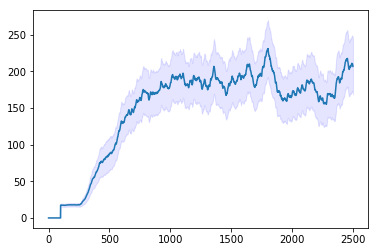

In [30]:
bayes_max, bayes_auc, bayes_df = plot_results(res, 100, 0.2)
plt.savefig("bayes_cp.png")

In [28]:
print bayes_max, bayes_auc

186.35 91.645872


In [29]:
bayes_df.to_csv("bayes.csv")